In [19]:
! pip install mplfinance

##Import libraries

In [20]:
import os
from pathlib import Path
import pandas as pd
import sklearn
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    r2_score,
    mean_absolute_percentage_error
)

### Defin indexes





In [21]:
def compute_rsi(prices, period=14):
    """
    Compute the Relative Strength Index (RSI) for a series of prices.
    Returns a 1D numpy array of RSI values. The first (period-1) values will be NaN.
    """
    prices = np.array(prices)
    deltas = np.diff(prices)
    seed = deltas[:period]
    up = seed[seed >= 0].sum() / period
    down = -seed[seed < 0].sum() / period
    rs = up / down if down != 0 else 0
    rsi = np.zeros_like(prices)
    rsi[:period] = np.nan
    rsi[period - 1] = 100. - 100. / (1. + rs)
    for i in range(period, len(prices)):
        delta = deltas[i - 1]
        if delta > 0:
            upval = delta
            downval = 0
        else:
            upval = 0
            downval = -delta
        up = (up * (period - 1) + upval) / period
        down = (down * (period - 1) + downval) / period
        rs = up / down if down != 0 else 0
        rsi[i] = 100. - 100. / (1. + rs)
    return rsi

def compute_macd(prices, fast=12, slow=26, signal=9):
    """
    Compute the MACD (Moving Average Convergence Divergence) for a series of prices.
    Returns a tuple of three 1D numpy arrays: (macd, signal_line, histogram).
    """
    prices = pd.Series(np.array(prices).flatten())
    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    histogram = macd - signal_line
    return macd.values, signal_line.values, histogram.values

In [22]:
# Check if a CUDA-compatible GPU is available. If yes, use it; otherwise, fall back to the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

csv_file_path = '/content/bit_sen.csv'

# Extract base name without extension for naming
csv_base = Path(csv_file_path).stem

# Define paths for saving the best model and its metrics
model_history_dir = Path('model_history')
result_history_dir = Path('result_history')

os.makedirs(model_history_dir, exist_ok=True)
os.makedirs(result_history_dir, exist_ok=True)

best_model_filename = f"{csv_base}_best_model.pt"
best_model_path = model_history_dir / best_model_filename
metrics_path = result_history_dir / f"{csv_base}_metrics.txt"

forecast_history = 24  # Number of past time steps to use for input sequences.
forecast_horizon = 1  # Number of future time steps to predict (e.g., 0 means predicting the next step immediately).

batch_size = 64  # Number of samples in each mini-batch
max_iterations = 100
model_name = 'mLstm'

best_mse = float('inf')

###Preprocess

In [23]:
# Load Data
try:
  df_raw = pd.read_csv(csv_file_path)
  print("CSV file loaded successfully.")
except Exception as e:
  print(f"Error reading CSV file: {e}")

df_raw.head(10)

CSV file loaded successfully.


,positive,negetive,neutral,Date,Price,Open,High,Low,Vol.,Change %
0,0.116094,0.789252,0.094654,2015-01-01,313.9,317.5,317.5,312.9,0.93K,-0.99%
1,0.113846,0.795338,0.090816,2015-01-02,315.1,313.6,316.0,313.0,1.32K,0.40%
2,0.114822,0.795150,0.090027,2015-01-03,282.0,314.8,314.8,282.0,1.30K,-10.51%
3,0.114798,0.790363,0.094839,2015-01-04,258.8,282.0,288.9,258.8,2.38K,-8.23%
4,0.117028,0.790906,0.092066,2015-01-05,273.2,261.0,276.5,260.5,2.68K,5.57%
5,0.113413,0.791942,0.094645,2015-01-06,285.4,273.2,287.8,268.5,6.86K,4.46%
6,0.117202,0.788809,0.093989,2015-01-07,297.0,286.1,303.8,285.0,1.53K,4.07%
7,0.114490,0.784668,0.100843,2015-01-08,285.6,296.2,296.2,285.6,1.31K,-3.82%
8,0.111742,0.798039,0.090218,2015-01-09,292.8,285.4,295.6,283.0,1.26K,2.52%
9,0.113061,0.791843,0.095096,2015-01-10,275.0,292.4,292.4,271.0,1.11K,-6.08%


In [24]:
# Preprocess data
datetime_col = "Date"
freq = '1D'
columns = ['Price']
method = 'ffill'
value = 0


# Define a data preprocessing pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    # Step 1: Drop duplicate rows based on the datetime column
    ('drop_duplicates', sklearn.preprocessing.FunctionTransformer(lambda df: df.drop_duplicates(subset=datetime_col))),

    # Step 2: Fill missing values in the dataset
    ('fill_missing', sklearn.preprocessing.FunctionTransformer(
        lambda df: df.fillna(method=method).fillna(value=value)  # Fill missing values using a specified method and value
    ))
])

# Apply the pipeline to the raw data
df = preproc_pipe.fit_transform(df_raw)

# Convert the datetime column to a standard datetime format
df[datetime_col] = pd.to_datetime(df[datetime_col])

# Sort the data by the datetime column in ascending order
df = df.sort_values(by=datetime_col)



<ipython-input-24-9782ae18296c>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda df: df.fillna(method=method).fillna(value=value)  # Fill missing values using a specified method and value


In [25]:
# Define the proportions for test and validation sets
test_size = 0.05  # Fraction of the data to be used as the test set
valid_size = 0.05  # Fraction of the data to be used as the validation set

# Calculate the total number of samples in the dataset
total_size = len(df)  # The total number of rows in the DataFrame

# Calculate the number of samples for the test set
test_split = int(total_size * test_size)  # Convert the test size fraction to the actual count

# Calculate the number of samples for the validation set
valid_split = int(total_size * valid_size)  # Convert the validation size fraction to the actual count

# Calculate the end index of the training set (exclusive)
train_end = total_size - test_split - valid_split  # Determine where the training set ends

# Calculate the end index of the validation set (exclusive)
valid_end = total_size - test_split  # Determine where the validation set ends

# Split the data into training, validation, and test sets using indices
train_df = df.iloc[:train_end]  # Select rows for the training set
valid_df = df.iloc[train_end:valid_end]  # Select rows for the validation set
test_df = df.iloc[valid_end:]  # Select rows for the test set

# Print the sizes of each split for verification
print(f"Data split into train ({len(train_df)}), validation ({len(valid_df)}), and test ({len(test_df)}) sets.")


Data split into train (1608), validation (89), and test (89) sets.


In [26]:
# Define the columns to be scaled
scale_columns = ['Price']  # Specify the column(s) to scale, in this case 'Price'

# Initialize the MinMaxScaler with a feature range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler using the training data
scaler.fit(train_df[scale_columns])  # Calculate the min and max values from the training set for scaling



# Transform the test data using the same scaler
test_scaled = scaler.transform(test_df[scale_columns])  # Apply the same scaling to the test set

# Print a message indicating that the scaling is complete
print("Data scaling completed.")


Data scaling completed.


In [27]:
# Function to create input-output sequences for training/testing
def create_sequences(data, seq_length, horizon):
    """
    Generate sequences of input features (X) and corresponding target values (y).

    Args:
        data: The scaled dataset to create sequences from.
        seq_length: Number of past time steps to use as input.
        horizon: Number of future time steps to predict.


    Returns:
        X (Tensor): Tensor of input sequences.
        y (Tensor): Tensor of target values corresponding to the sequences.
    """
    X, y = [], []  # Initialize empty lists for input (X) and output (y)

    # Iterate over the dataset to create sequences
    for i in range(len(data) - seq_length - horizon + 1):  # Ensure valid indices for sequences
        X.append(data[i:(i + seq_length)])  # Extract 'seq_length' past time steps
        y.append(data[i + seq_length + horizon - 1])  # Extract the target value at the specified horizon
    return torch.Tensor(X), torch.Tensor(y)  # Convert lists to PyTorch tensors for use in models



# Create input and output sequences for the test set
testX, testY = create_sequences(test_scaled, forecast_history, forecast_horizon)

print('Data sequence is created.')

Data sequence is created.


###Define model

In [28]:
# Naive forecast: prediction = last value of each sequence

###Train

In [29]:
def log_print(*args, **kwargs):
    with open(metrics_path, 'a') as metrics_file:
        msg = ' '.join(map(str, args))
        print(msg)
        metrics_file.write(msg + '\n')

In [30]:
 #The naive forecast model does not require training.

###Evalute

In [31]:
include_baseline  = True

In [32]:
naive_preds = testX[:, -1, 0]

test_predictions = scaler.inverse_transform(naive_preds.reshape(-1, 1)).flatten()
actuals = scaler.inverse_transform(testY.reshape(-1, 1)).flatten()

mse_val = mean_squared_error(actuals, test_predictions)
mae_val = mean_absolute_error(actuals, test_predictions)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(actuals, test_predictions)
mape_val = mean_absolute_percentage_error(actuals, test_predictions)

log_print("\nTest Regression Metrics:")
log_print(f"\nFinal Test MSE: {mse_val:.6f}")
log_print(f"Final Test MAE: {mae_val:.6f}")
log_print(f"  R2   : {r2_val:.6f}")
log_print(f"  MAPE : {mape_val:.6f}")


log_print(f"\nTest Metrics saved at '{metrics_path}'")

# --- Additional RSI and MACD Metrics ---
if len(actuals) >= 14:
    rsi_actual = compute_rsi(actuals, period=14)
    rsi_pred = compute_rsi(test_predictions, period=14)
    valid_idx = ~np.isnan(rsi_actual)
    if valid_idx.sum() > 0:
        rsi_mae = mean_absolute_error(rsi_actual[valid_idx], rsi_pred[valid_idx])
        rsi_mse = mean_squared_error(rsi_actual[valid_idx], rsi_pred[valid_idx])
        log_print("\nRSI Metrics:")
        log_print(f"  RSI MAE: {rsi_mae:.4f}")
        log_print(f"  RSI MSE: {rsi_mse:.4f}")
if len(actuals) >= 26:
    def compute_macd_local(prices, fast=12, slow=26, signal=9):
        prices = pd.Series(np.array(prices).flatten())
        ema_fast = prices.ewm(span=fast, adjust=False).mean()
        ema_slow = prices.ewm(span=slow, adjust=False).mean()
        macd = ema_fast - ema_slow
        signal_line = macd.ewm(span=signal, adjust=False).mean()
        histogram = macd - signal_line
        return macd.values, signal_line.values, histogram.values
    macd_actual, _, _ = compute_macd_local(actuals)
    macd_pred, _, _ = compute_macd_local(test_predictions)
    macd_mae = mean_absolute_error(macd_actual, macd_pred)
    log_print("\nMACD Metric:")
    log_print(f"  MACD MAE: {macd_mae:.4f}")


Test Regression Metrics:

Final Test MSE: 90309.109403
Final Test MAE: 195.009248
  R2   : 0.781433
  MAPE : 0.022846

Test Metrics saved at 'result_history/bit_sen_metrics.txt'

RSI Metrics:
  RSI MAE: 3.2245
  RSI MSE: 28.6533

MACD Metric:
  MACD MAE: 34.4315


In [33]:
model_name = 'naive'


In [34]:
from google.colab import drive
drive.mount('/content/drive')
try:
  results = pd.read_csv('/content/drive/MyDrive/bitcoin/results.csv')
except Exception as e:
  print(e)
  results = pd.DataFrame(columns=['model','MSE', 'MAE','R2_score','MAPE','time frame', 'type'])

results.loc[len(results)] = [model_name, mse_val, mae_val, r2_val, mape_val, '2015_2019' , 'h']
results.to_csv('/content/drive/MyDrive/bitcoin/results.csv', index=False)
results

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,model,MSE,MAE,R2_score,MAPE,time frame,type
0,Lstm,1.389904e+05,264.869904,0.663615,0.031106,2015_2019,h
1,Lstm,1.235698e+07,2656.415283,0.959166,0.030248,2015_2025,h
2,mLstm,4.015359e+06,1431.601807,0.986731,0.017758,2015_2025,h
3,sLstm,1.144006e+05,250.424500,0.723127,0.029518,2015_2019,h
4,xLstm,1.270245e+05,274.627167,0.692575,0.032396,2015_2019,h
5,Arima,9.475766e+05,807.973482,-0.114735,0.086864,2015_2019,h
6,Arima,1.589004e+09,35780.719331,-4.145886,0.432990,2015_2025,h
7,sLstm,4.004088e+06,1430.421387,0.986768,0.017746,2015_2025,h
8,prophtet,2.454878e+09,46797.422130,-6.949964,0.586149,2015_2025,h
9,prophtet,2.901797e+07,5342.608098,-33.136929,0.591624,2015_2019,h


In [ ]:
# Direction Classification Metrics (Test)
actual_dirs = []
predicted_dirs = []
for i in range(1, len(actuals)):
    actual_dir = 1 if actuals[i] > actuals[i - 1] else 0
    pred_dir = 1 if test_predictions[i] > actuals[i - 1] else 0
    actual_dirs.append(actual_dir)
    predicted_dirs.append(pred_dir)
acc_val = accuracy_score(actual_dirs, predicted_dirs)
prec_val = precision_score(actual_dirs, predicted_dirs, zero_division=0)
rec_val = recall_score(actual_dirs, predicted_dirs, zero_division=0)
f1_val = f1_score(actual_dirs, predicted_dirs, zero_division=0)
log_print("\nTest Direction Classification Metrics:")
log_print(f"  Accuracy : {acc_val:.4f}")
log_print(f"  Precision: {prec_val:.4f}")
log_print(f"  Recall   : {rec_val:.4f}")
log_print(f"  F1       : {f1_val:.4f}")




Test Direction Classification Metrics:
  Accuracy : 0.4494
  Precision: 0.0000
  Recall   : 0.0000
  F1       : 0.0000


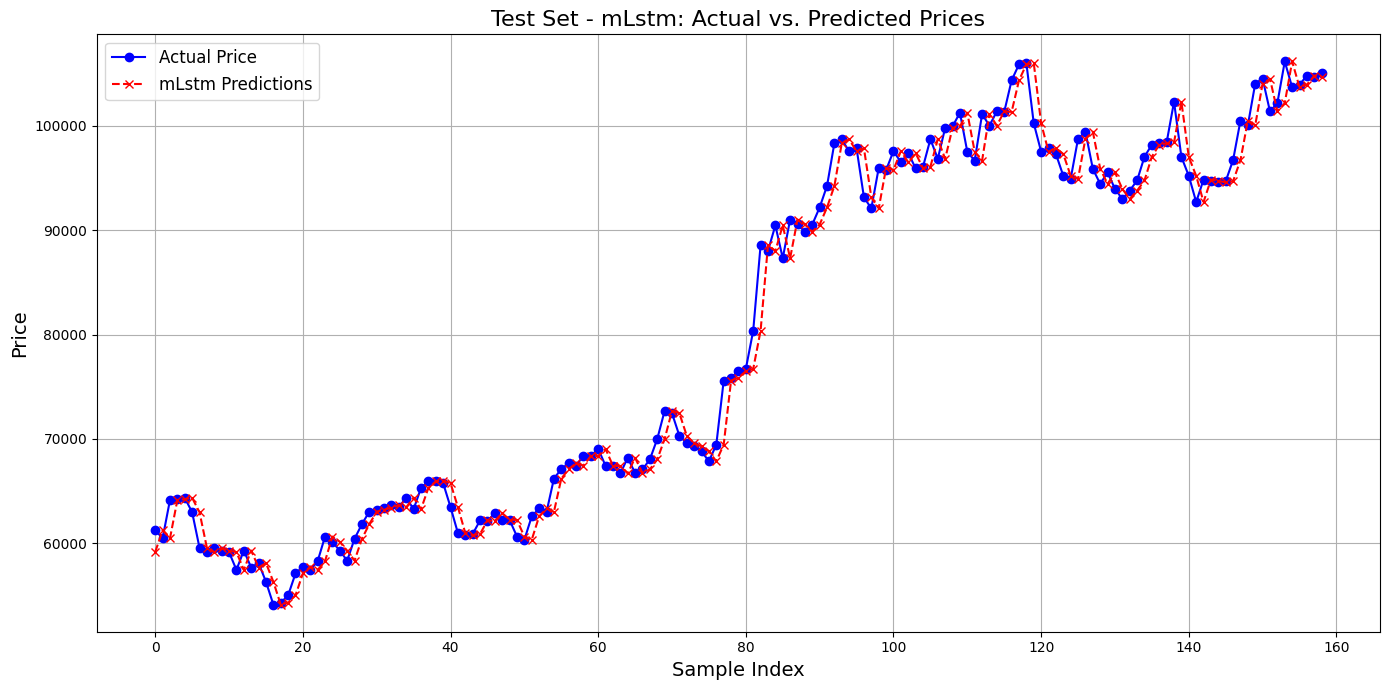

Test price plot saved to 'result_history/BTC_USD_24_1_test_price_plot.png'


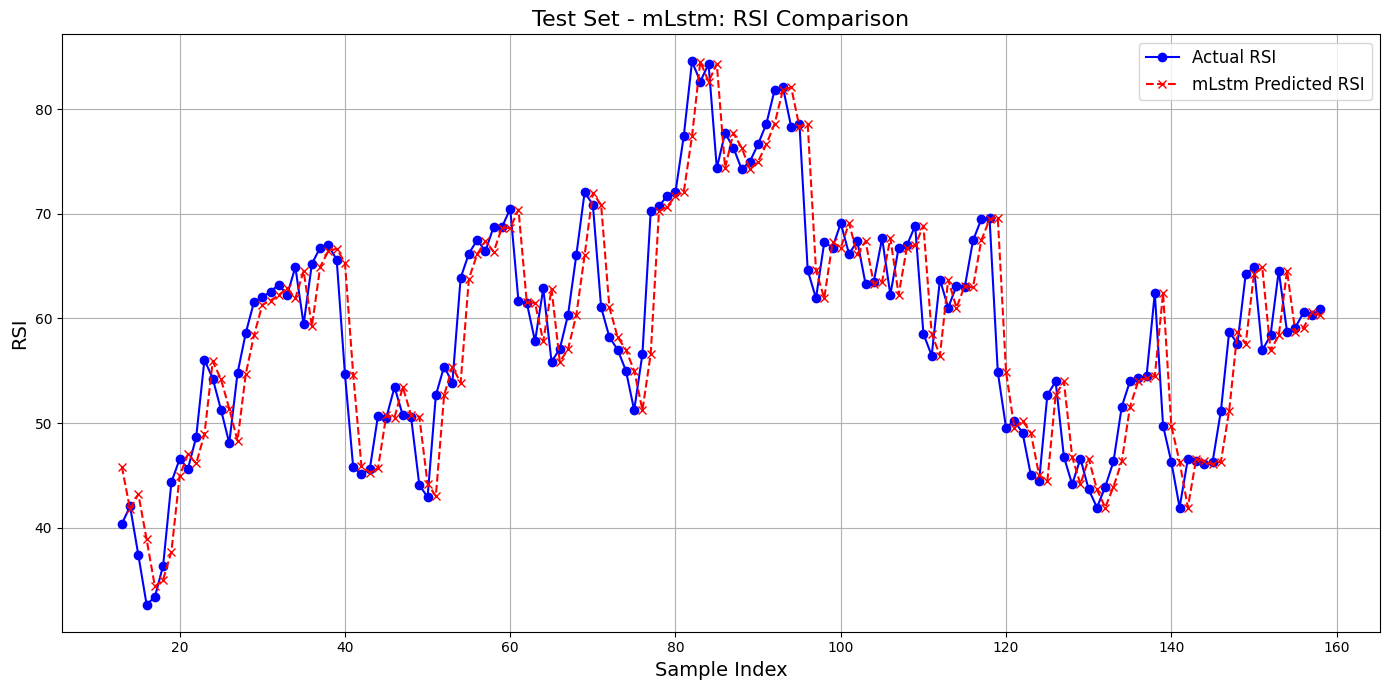

Test RSI comparison plot saved to 'result_history/BTC_USD_24_1_test_rsi_plot.png'


/usr/local/lib/python3.11/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


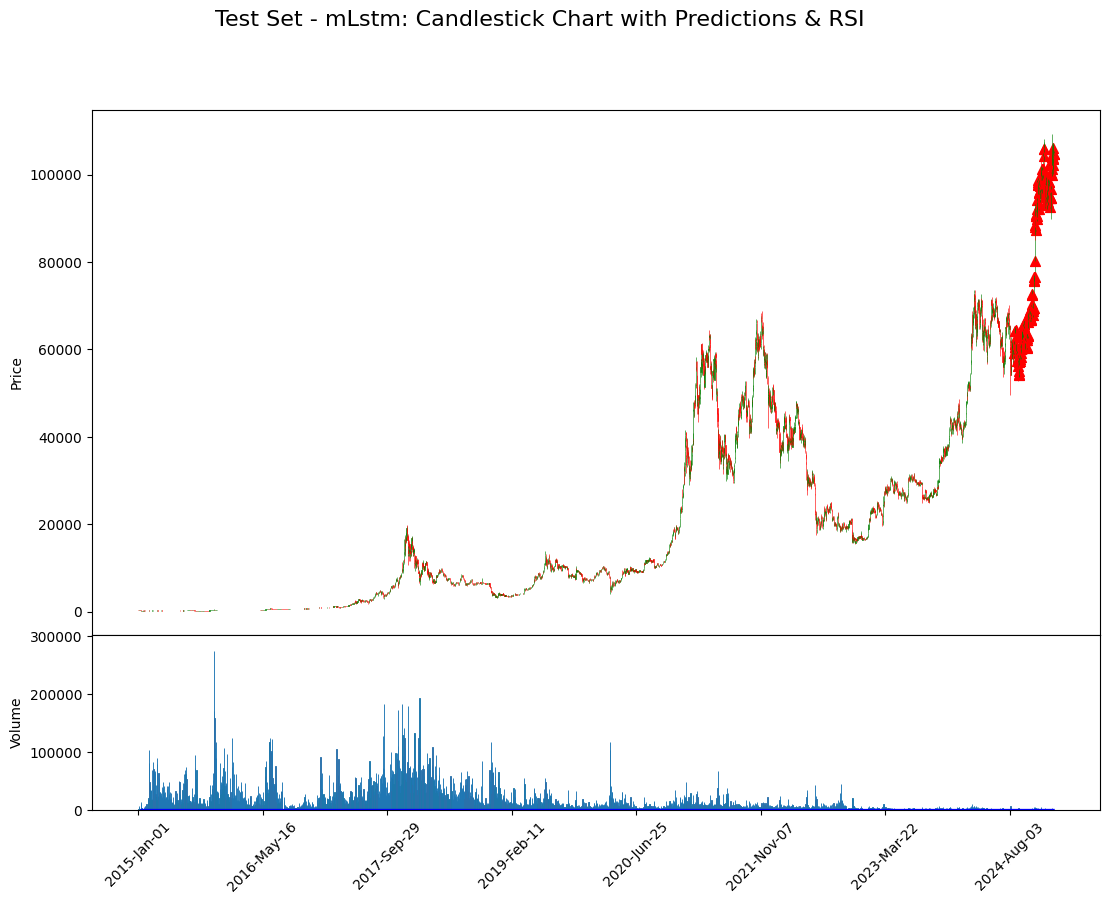

Test candlestick chart saved to 'result_history/BTC_USD_24_1_candlestick.png'

Evaluation completed for 'BTC_USD' with model 'mLstm' and forecast_history=24.
Metrics and plots appended to 'result_history/BTC_USD_metrics.txt' and saved in 'result_history'


In [ ]:
# Plot: Actual vs. Predicted Prices (Test Set)
try:
    indices = np.arange(len(actuals))
    plt.figure(figsize=(14, 7))
    plt.plot(indices, actuals, label='Actual Price', marker='o', linestyle='-', color='blue')
    plt.plot(indices, test_predictions, label=f"{model_name} Predictions", marker='x', linestyle='--', color='red')

    plt.xlabel('Sample Index', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.title(f"Test Set - {model_name}: Actual vs. Predicted Prices", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    price_plot_filename = f"{csv_base}_{forecast_history}_{forecast_horizon}_test_price_plot.png"
    price_plot_path = result_history_dir / price_plot_filename
    plt.savefig(price_plot_path)
    plt.show()
    plt.close()
    log_print(f"Test price plot saved to '{price_plot_path}'")
except Exception as e:
    log_print(f"Error during test price plotting: {e}")

# Plot: RSI Comparison (Test Set)
try:
    indices = np.arange(len(actuals))
    plt.figure(figsize=(14, 7))
    rsi_actual = compute_rsi(actuals, period=14)
    rsi_pred = compute_rsi(test_predictions, period=14)
    plt.plot(indices, rsi_actual, label='Actual RSI', marker='o', linestyle='-', color='blue')
    plt.plot(indices, rsi_pred, label=f"{model_name} Predicted RSI", marker='x', linestyle='--', color='red')
    plt.xlabel('Sample Index', fontsize=14)
    plt.ylabel('RSI', fontsize=14)
    plt.title(f"Test Set - {model_name}: RSI Comparison", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    rsi_plot_filename = f"{csv_base}_{forecast_history}_{forecast_horizon}_test_rsi_plot.png"
    rsi_plot_path = result_history_dir / rsi_plot_filename
    plt.savefig(rsi_plot_path)
    plt.show()
    plt.close()
    log_print(f"Test RSI comparison plot saved to '{rsi_plot_path}'")
except Exception as e:
    log_print(f"Error during test RSI plotting: {e}")

# Test Candlestick Chart with Predictions & RSI
try:
    df_candle = df_raw.copy()
    df_candle[datetime_col] = pd.to_datetime(df_candle[datetime_col])
    df_candle = df_candle.sort_values(by=datetime_col)
    if 'Price' in df_candle.columns:
        df_candle.rename(columns={'Price': 'Close'}, inplace=True)
    if 'Vol.' in df_candle.columns:
        df_candle.rename(columns={'Vol.': 'Volume'}, inplace=True)
        df_candle['Volume'] = df_candle['Volume'].apply(
            lambda x: float(x.replace('K', '')) * 1000 if isinstance(x, str) and 'K' in x else float(x)
        )
    df_candle.set_index(datetime_col, inplace=True)
    rsi_values = compute_rsi(df_candle['Close'].values, period=14)
    df_candle['RSI'] = rsi_values
    # Use the Date column from test_df as the index for predictions
    test_index = pd.to_datetime(test_df[datetime_col])
    n_missing = forecast_history + forecast_horizon - 1
    pred_full = [np.nan] * n_missing + list(test_predictions.flatten())
    pred_full = pred_full[:len(test_index)]
    pred_series = pd.Series(pred_full, index=test_index)
    df_candle.loc[test_index, 'Predicted'] = pred_series
    apds = [
        mpf.make_addplot(df_candle['RSI'], panel=1, color='blue', ylabel='RSI'),
        mpf.make_addplot(df_candle['Predicted'], type='scatter', markersize=50, marker='^', color='red', panel=0)
    ]
    mc = mpf.make_marketcolors(up='g', down='r', inherit=True)
    style = mpf.make_mpf_style(marketcolors=mc)
    volume_flag = True if 'Volume' in df_candle.columns else False
    fig, axlist = mpf.plot(df_candle, type='candle', style=style, volume=volume_flag,
                            addplot=apds, returnfig=True, figsize=(14, 10), panel_ratios=(3, 1))
    fig.suptitle(f"Test Set - {model_name}: Candlestick Chart with Predictions & RSI", fontsize=16)
    candle_plot_filename = f"{csv_base}_{forecast_history}_{forecast_horizon}_candlestick.png"
    candle_plot_path = result_history_dir / candle_plot_filename
    fig.savefig(candle_plot_path)
    plt.show()
    plt.close(fig)
    log_print(f"Test candlestick chart saved to '{candle_plot_path}'")
except Exception as e:
    log_print(f"Error during test candlestick plotting: {e}")

log_print(f"\nEvaluation completed for '{csv_base}' with model '{model_name}' and forecast_history={forecast_history}.")
log_print(f"Metrics and plots appended to '{metrics_path}' and saved in '{result_history_dir}'")